In [10]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Load the CSV files
train_data_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\19X400X150_patch90_coordinates\landmark_2_coordinates.csv')

# Combine the dataframes
df = train_data_df
# Adjust the splitting ratios
train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

# Split the dataframe into train, test, and validation sets
train_df, test_val_df = train_test_split(df, test_size=(test_ratio + val_ratio), random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=val_ratio/(test_ratio + val_ratio), random_state=42)

# Print the number of data points in each set
print("Number of data points in train set:", len(train_df))
print("Number of data points in validation set:", len(val_df))
print("Number of data points in test set:", len(test_df))

# Data augmentation configuration
# Data augmentation configuration
data_gen_args = {
    'rescale': 0.004,  # Rescale with a factor of 0.004
    'horizontal_flip': True,  # Horizontal flipping
    'vertical_flip': False,  # Vertical flipping is not included
    'zoom_range': 0.2,  # Zooming in and out by a factor of 2
    'shear_range': 2.0,  # Random shearing with a factor of 2
    'rotation_range': 0,  # Rotation is not included
    'fill_mode': 'nearest'
}


# ImageDataGenerator for training
train_datagen = ImageDataGenerator(**data_gen_args)

# ImageDataGenerator for testing/validation
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator for training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_patch90\landmark_2',
    x_col='patch_filename',
    y_col=['x', 'y'],
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=True
)

# Generator for validation data
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_patch90\landmark_2',
    x_col='patch_filename',
    y_col=['x', 'y'],
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

# Generator for test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_patch90\landmark_2',
    x_col='patch_filename',
    y_col=['x', 'y'],
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

# Save test data to CSV
test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\tes_CephaXnet_L2.csv', index=False)


Number of data points in train set: 41999
Number of data points in validation set: 6001
Number of data points in test set: 12000
Found 41999 validated image filenames.
Found 6001 validated image filenames.
Found 12000 validated image filenames.


In [11]:
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Reshape, Multiply, Add, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Adjust dropout rate
dropout_rate = 0.3

# Define the Squeeze-and-Excitation Block
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)

    x = Multiply()([init, se])
    return x

# Define the CNM Layer
def cnm_layer(input_tensor, filters, kernel_size=(3,3), pool_size=(2,2)):
    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size)(x)
    return x

# Input layer
input_layer = Input(shape=(64, 64, 1))  # You may need to adjust the input shape

# First CNM Layer
cnml1 = cnm_layer(input_layer, 32)
cnml1 = cnm_layer(cnml1, 64)

# Squeeze-and-Excitation Block
seb = squeeze_excite_block(cnml1)

# Skip Connection with element-wise summation
skip_connection = Add()([cnml1, seb])

# Second CNM Layer with skip connection as input
cnml2 = cnm_layer(skip_connection, 128)
cnml2 = cnm_layer(cnml2, 256)

# Flatten and Dense layers for regression
flatten = Flatten()(cnml2)
dropout = Dropout(dropout_rate)(flatten)  # Adjusted dropout rate
dense = Dense(512, activation='relu')(dropout)
dropout = Dropout(dropout_rate)(dense)  # Adjusted dropout rate
dense = Dense(256, activation='relu')(dropout)

# Output layer for regression
output_regression = Dense(2, activation='relu')(dense)  # Assuming 19 landmarks to predict

# Create the model
model = Model(inputs=input_layer, outputs=output_regression)

# Define optimizer without the decay argument
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)  

# Compile the model with the specified optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error')  # Using mean squared error for regression

# Model Summary
model.summary()



Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 32, 32,    │          0 │ re_lu_12[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_13 (ReLU)     │ (None, 32, 32,    │          0 │ conv2d_13[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 16, 16,    │          0 │ re_lu_13[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_13… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1, 1, 4)   │        260 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1, 1, 64)  │        320 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 16, 16,    │          0 │ max_pooling2d_13… │
│ (Multiply)          │ 64)               │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 16, 16,    │          0 │ max_pooling2d_13… │
│                     │ 64)               │            │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │     73,856 │ add_3[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 16, 16,    │          0 │ conv2d_14[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 8, 8, 128) │          0 │ re_lu_14[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 8, 8, 256) │          0 │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,617,926 (9.99 MB)

 Trainable params: 2,617,926 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 457s 345ms/step - loss: 159.8077 - val_loss: 77.3775
Epoch 2/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 120s 91ms/step - loss: 74.2941 - val_loss: 50.4862
Epoch 3/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 117s 88ms/step - loss: 52.7062 - val_loss: 36.3818
Epoch 4/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 111s 84ms/step - loss: 38.6747 - val_loss: 23.0159
Epoch 5/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 103s 78ms/step - loss: 28.6446 - val_loss: 17.4668
Epoch 6/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 78s 59ms/step - loss: 22.5669 - val_loss: 13.6793
Epoch 7/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 110s 84ms/step - loss: 19.3001 - val_loss: 12.9461
Epoch 8/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 113s 85ms/step - loss: 16.7978 - val_loss: 11.8693
Epoch 9/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 119s 90ms/step - loss: 14.8474 - val_loss: 9.0238
Epoch 10/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 114s 87ms/step - loss: 13.1140 - val_loss: 8.3896
Epoch 11/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 119s 90ms/step - loss: 11.9905 - val_l

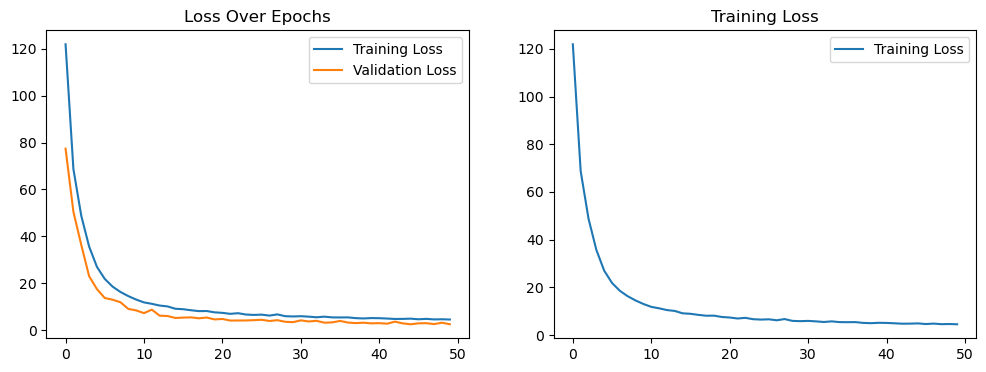

In [12]:
import time
import matplotlib.pyplot as plt

# Start training
start_time = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1  # Added verbose argument to provide training progress
)

# End time
end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f} seconds")

# Plot the training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

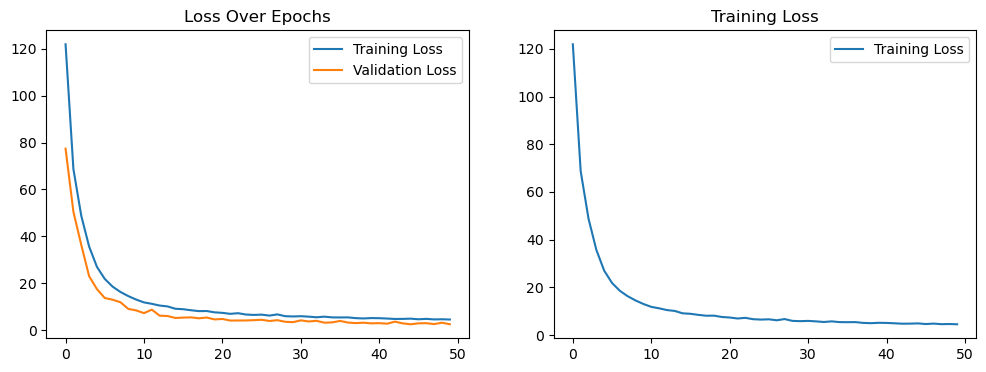

In [15]:
import matplotlib.pyplot as plt

# Your code to plot the training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.legend()

# Save the graph as JPG
plt.savefig(r'C:\Users\Student\Desktop\Shalu\All Graphs\CephaNet_l2', dpi=300)  # Specify the file name and dpi (dots per inch)
plt.show()


In [13]:

# Save the trained model to a specific directory
model.save(r'C:\Users\Student\Desktop\Shalu\CephaNet__L2.h5')


In [17]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load test data and prepare generator
test_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\tes_CephaXnet_L2.csv',)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_patch90\landmark_2',
    x_col='patch_filename',
    y_col=['x', 'y'],  # Ensure column names match your actual data
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

# Predict the coordinates on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Add predictions to the dataframe
test_df[['predicted_x', 'predicted_y']] = predictions

# Save the dataframe with true and predicted coordinates to CSV
#test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\cephaXnet_predictions_My_L1.csv', index=False)
#print("Predictions saved to CSV file.")


Found 12000 validated image filenames.


C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 97s 257ms/step


In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load predictions CSV
predictions_df = test_df

# Calculate Euclidean distances (errors) between true and predicted coordinates for each landmark
errors = np.sqrt((predictions_df['x'] - predictions_df['predicted_x'])**2 + (predictions_df['y'] - predictions_df['predicted_y'])**2)

# Define precision ranges in pixels (given pixel spacing is 0.1mm)
precision_ranges_mm = [2, 2.5, 3, 4]  # Precision ranges in millimeters
precision_ranges_pixels = [x / 0.1 for x in precision_ranges_mm]  # Convert mm to pixels

# Calculate SDR within each precision range
sdr_values = {}
for threshold_pixels in precision_ranges_pixels:
    sdr = np.mean(errors < threshold_pixels) * 100  # Calculate the percentage of landmarks within the threshold
    sdr_values[f"{threshold_pixels * 0.1}mm"] = f"{sdr:.2f}%"

# Display SDR values
print("SDR within precision ranges:", sdr_values)

# Save SDR values to a CSV file
#sdr_df = pd.DataFrame(list(sdr_values.items()), columns=['Precision Range', 'SDR'])
#sdr_df.to_csv('/content/drive/MyDrive/ISBI_Dataset/sdr_values1.csv', index=False)
#print("SDR values saved to CSV file.")


SDR within precision ranges: {'2.0mm': '100.00%', '2.5mm': '100.00%', '3.0mm': '100.00%', '4.0mm': '100.00%'}


## Test1

In [20]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load test data and prepare generator
test_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\19X400X150_test1patch90_coordinates\landmark_2_coordinates.csv',)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_test1patch90\landmark_2',
    x_col='patch_filename',
    y_col=['x', 'y'],  # Ensure column names match your actual data
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

# Predict the coordinates on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Add predictions to the dataframe
test_df[['predicted_x', 'predicted_y']] = predictions

# Save the dataframe with true and predicted coordinates to CSV
#test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\cephaXnet_predictions_My_L1.csv', index=False)
#print("Predictions saved to CSV file.")


Found 60000 validated image filenames.
   1/1875 ━━━━━━━━━━━━━━━━━━━━ 9:38 308ms/step

C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 598s 319ms/step


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load predictions CSV
predictions_df = test_df

# Calculate Euclidean distances (errors) between true and predicted coordinates for each landmark
errors = np.sqrt((predictions_df['x'] - predictions_df['predicted_x'])**2 + (predictions_df['y'] - predictions_df['predicted_y'])**2)

# Define precision ranges in pixels (given pixel spacing is 0.1mm)
precision_ranges_mm = [2, 2.5, 3, 4]  # Precision ranges in millimeters
precision_ranges_pixels = [x / 0.1 for x in precision_ranges_mm]  # Convert mm to pixels

# Calculate SDR within each precision range
sdr_values = {}
for threshold_pixels in precision_ranges_pixels:
    sdr = np.mean(errors < threshold_pixels) * 100  # Calculate the percentage of landmarks within the threshold
    sdr_values[f"{threshold_pixels * 0.1}mm"] = f"{sdr:.2f}%"

# Display SDR values
print("SDR within precision ranges:", sdr_values)

# Save SDR values to a CSV file
#sdr_df = pd.DataFrame(list(sdr_values.items()), columns=['Precision Range', 'SDR'])
#sdr_df.to_csv('/content/drive/MyDrive/ISBI_Dataset/sdr_values1.csv', index=False)
#print("SDR values saved to CSV file.")


SDR within precision ranges: {'2.0mm': '88.42%', '2.5mm': '92.91%', '3.0mm': '96.26%', '4.0mm': '99.45%'}


## Test2

In [24]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load test data and prepare generator
test_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\19X400X150_test2patch90_coordinates\landmark_2_coordinates.csv',)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_test2patch90\landmark_2',
    x_col='patch_filename',
    y_col=['x', 'y'],  # Ensure column names match your actual data
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

# Predict the coordinates on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Add predictions to the dataframe
test_df[['predicted_x', 'predicted_y']] = predictions

# Save the dataframe with true and predicted coordinates to CSV
#test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\cephaXnet_predictions_My_L1.csv', index=False)
#print("Predictions saved to CSV file.")


Found 40000 validated image filenames.
   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:11 57ms/step

C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 192s 154ms/step


In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load predictions CSV
predictions_df = test_df

# Calculate Euclidean distances (errors) between true and predicted coordinates for each landmark
errors = np.sqrt((predictions_df['x'] - predictions_df['predicted_x'])**2 + (predictions_df['y'] - predictions_df['predicted_y'])**2)

# Define precision ranges in pixels (given pixel spacing is 0.1mm)
precision_ranges_mm = [2, 2.5, 3, 4]  # Precision ranges in millimeters
precision_ranges_pixels = [x / 0.1 for x in precision_ranges_mm]  # Convert mm to pixels

# Calculate SDR within each precision range
sdr_values = {}
for threshold_pixels in precision_ranges_pixels:
    sdr = np.mean(errors < threshold_pixels) * 100  # Calculate the percentage of landmarks within the threshold
    sdr_values[f"{threshold_pixels * 0.1}mm"] = f"{sdr:.2f}%"

# Display SDR values
print("SDR within precision ranges:", sdr_values)

# Save SDR values to a CSV file
#sdr_df = pd.DataFrame(list(sdr_values.items()), columns=['Precision Range', 'SDR'])
#sdr_df.to_csv('/content/drive/MyDrive/ISBI_Dataset/sdr_values1.csv', index=False)
#print("SDR values saved to CSV file.")


SDR within precision ranges: {'2.0mm': '91.24%', '2.5mm': '95.44%', '3.0mm': '98.01%', '4.0mm': '99.72%'}


## Image Registration Test1

In [22]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load test data and prepare generator
test_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\Test1_Coordinate\L_2.csv')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\All_ROIs_test1',
    x_col='patch_filename',
    y_col=['reference_x', 'reference_y','test_original_x','test_original_x'],  # Ensure column names match your actual data
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

# Predict the coordinates on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Add predictions to the dataframe
test_df[['predicted_x', 'predicted_y']] = predictions
# Add two additional columns x and y with adjusted values
test_df['x'] = test_df['reference_x'] - 45 + test_df['predicted_x']
test_df['y'] = test_df['reference_y'] - 45 + test_df['predicted_y']

# Save the dataframe with true and predicted coordinates to CSV
test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\test1_L2.csv', index=False)
print("Predictions saved to CSV file.")

Found 150 validated image filenames.
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step

C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
Predictions saved to CSV file.


In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load predictions CSV
predictions_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\test1_L2.csv')

# Calculate Euclidean distances (errors) between true and predicted coordinates for each landmark
errors = np.sqrt((predictions_df['x'] - predictions_df['test_original_x'])**2 + (predictions_df['y'] - predictions_df['test_original_y'])**2)

# Define precision ranges in pixels (given pixel spacing is 0.1mm)
precision_ranges_mm = [2, 2.5, 3, 4]  # Precision ranges in millimeters
precision_ranges_pixels = [x / 0.1 for x in precision_ranges_mm]  # Convert mm to pixels

# Calculate SDR within each precision range
sdr_values = {}
for threshold_pixels in precision_ranges_pixels:
    sdr = np.mean(errors < threshold_pixels) * 100  # Calculate the percentage of landmarks within the threshold
    sdr_values[f"{threshold_pixels * 0.1}mm"] = f"{sdr:.2f}%"

# Display SDR values
print("SDR within precision ranges:", sdr_values)

# Save SDR values to a CSV file
#sdr_df = pd.DataFrame(list(sdr_values.items()), columns=['Precision Range', 'SDR'])
#sdr_df.to_csv('/content/drive/MyDrive/ISBI_Dataset/sdr_values1.csv', index=False)
#print("SDR values saved to CSV file.")


SDR within precision ranges: {'2.0mm': '28.67%', '2.5mm': '32.67%', '3.0mm': '34.00%', '4.0mm': '42.67%'}


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load test data and prepare generator
test_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\Test1_512Coordinate\L_2.csv')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\All_512X512_ROIs_test1',
    x_col='patch_filename',
    y_col=['reference_x', 'reference_y','test_original_x','test_original_x'],  # Ensure column names match your actual data
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

# Predict the coordinates on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Add predictions to the dataframe
test_df[['predicted_x', 'predicted_y']] = predictions
# Add two additional columns x and y with adjusted values
test_df['x'] = test_df['reference_x'] - 45 + test_df['predicted_x']
test_df['y'] = test_df['reference_y'] - 45 + test_df['predicted_y']

# Save the dataframe with true and predicted coordinates to CSV
test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\test1_L2.csv', index=False)
print("Predictions saved to CSV file.")

Found 150 validated image filenames.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load predictions CSV
predictions_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\test1_L2.csv')

# Calculate Euclidean distances (errors) between true and predicted coordinates for each landmark
errors = np.sqrt((predictions_df['x'] - predictions_df['test_original_x'])**2 + (predictions_df['y'] - predictions_df['test_original_y'])**2)

# Define precision ranges in pixels (given pixel spacing is 0.1mm)
precision_ranges_mm = [2, 2.5, 3, 4]  # Precision ranges in millimeters
precision_ranges_pixels = [x / 0.1 for x in precision_ranges_mm]  # Convert mm to pixels

# Calculate SDR within each precision range
sdr_values = {}
for threshold_pixels in precision_ranges_pixels:
    sdr = np.mean(errors < threshold_pixels) * 100  # Calculate the percentage of landmarks within the threshold
    sdr_values[f"{threshold_pixels * 0.1}mm"] = f"{sdr:.2f}%"

# Display SDR values
print("SDR within precision ranges:", sdr_values)

# Save SDR values to a CSV file
#sdr_df = pd.DataFrame(list(sdr_values.items()), columns=['Precision Range', 'SDR'])
#sdr_df.to_csv('/content/drive/MyDrive/ISBI_Dataset/sdr_values1.csv', index=False)
#print("SDR values saved to CSV file.")
